# Emotion analysis on chat messages, using transformers.

In [14]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
CSV_DATASET_PATH = 'google_play_store_reviews.csv'

In [16]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split

## Load dataset

Samples in the dataset: 12495

                                             message sentiment
0                      I cannot open the app anymore  negative
1  I have been begging for a refund from this app...  negative
2  Very costly for the premium version (approx In...  negative
3  Used to keep me organized, but all the 2020 UP...  negative
4                                Dan Birthday Oct 28  negative



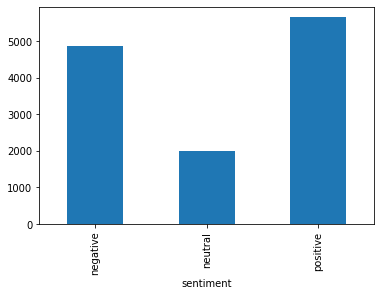

In [17]:
def score_to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

original_df = pd.read_csv(CSV_DATASET_PATH, sep=',')
df = pd.DataFrame()
df['message'] = original_df.content
df['sentiment'] = original_df.score.apply(score_to_sentiment)
df.dropna(inplace=True)
del original_df

print('Samples in the dataset:', df.shape[0], end='\n\n')
print(df.head(), end='\n\n')
df.groupby(['sentiment']).size().plot.bar()

## Test the tokenizer

In [18]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

example_text = 'This is a dummy phrase.'
bert_input = tokenizer(example_text, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")

print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'], end='\n\n')

example_text = tokenizer.decode(bert_input.input_ids[0])
print('Decode of the generated tokens:')
print(example_text)

tensor([[  101,  2023,  2003,  1037, 24369,  7655,  1012,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])

Decode of the generated tokens:
[CLS] this is a dummy phrase. [SEP] [PAD] [PAD]


## Dataset class declaration

In [19]:
from transformers import BertTokenizer

# The tokenizer is used in order to store tokens instead of text in the Dataset instances.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

SORTED_LABELS = sorted(df.sentiment.unique())  # We sort it because we want the labels order to be deterministic.
LABELS_KEYS = {sentiment: key for (key, sentiment) in enumerate(SORTED_LABELS)}
print('Labels keys', LABELS_KEYS, sep='\n')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        df.reset_index()
        self.df = df

    def __len__(self):
        return len(self.df['sentiment'])

    def __getitem__(self, idx):
        assert(isinstance(idx, int))

        text = self.df['message'].iloc[idx]
        tokenized_text = self._tokenize_text(text)
        
        sentiment = self.df['sentiment'].iloc[idx]
        y = np.array(LABELS_KEYS[sentiment])

        return tokenized_text, y

    def _tokenize_text(self, text):
      return tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

Labels keys
{'negative': 0, 'neutral': 1, 'positive': 2}


## Declare class weights to fix dataset imbalance

In [20]:
import sklearn
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes = [LABELS_KEYS[sentiment] for sentiment in SORTED_LABELS],
    y = [LABELS_KEYS[sentiment] for sentiment in df['sentiment']]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print('Class weights:', {sentiment: class_weights[LABELS_KEYS[sentiment]].item() for sentiment in SORTED_LABELS})

Class weights: {'negative': 0.8587628602981567, 'neutral': 2.0919137001037598, 'positive': 0.7366465926170349}


## Training, test, validation split
Let’s split our dataframe into training, validation, and test set with the proportion of 80:10:10.

In [21]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

9996 1249 1250


## Instantiate the model

In [22]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(LABELS_KEYS),
    classifier_dropout=0.3
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Training loop

In [ ]:
from torch.optim import Adam
from tqdm import tqdm


def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)

    BATCH_SIZE = 16
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        model.train()
        epoch_train_accuracy = 0
        epoch_train_loss = 0
        for train_inputs, train_labels in tqdm(train_dataloader):
            train_labels = train_labels.to(device)
            mask = train_inputs["attention_mask"].to(device)
            input_id = train_inputs["input_ids"].squeeze(1).to(device)

            optimizer.zero_grad()

            output = model(input_id, mask)
            batch_loss = criterion(output.logits, train_labels)

            batch_loss.backward()
            optimizer.step()

            epoch_train_loss += batch_loss.item()
            epoch_train_accuracy += (output.logits.argmax(dim=1) == train_labels).sum().item()

        epoch_validation_accuracy = 0
        with torch.no_grad():
            model.eval()
            for validation_inputs, validation_labels in val_dataloader:
                validation_labels = validation_labels.to(device)
                mask = validation_inputs["attention_mask"].to(device)
                input_id = validation_inputs["input_ids"].squeeze(1).to(device)

                output = model(input_id, mask)
                epoch_validation_accuracy += (output.logits.argmax(dim=1) == validation_labels).sum().item()

        print(
            f"Epochs: {epoch_num + 1} | Train Loss: {epoch_train_loss / len(train_data): .3f} \
                | Train Accuracy: {epoch_train_accuracy / len(train_data): .3f} \
                | Validation Accuracy: {epoch_validation_accuracy / len(val_data): .3f}"
        )


EPOCHS = 15
LR = 9e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 625/625 [15:14<00:00,  1.46s/it]


Epochs: 1 | Train Loss:  0.052                 | Train Accuracy:  0.661                 | Validation Accuracy:  0.677


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 2 | Train Loss:  0.041                 | Train Accuracy:  0.746                 | Validation Accuracy:  0.721


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 3 | Train Loss:  0.035                 | Train Accuracy:  0.800                 | Validation Accuracy:  0.737


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 4 | Train Loss:  0.028                 | Train Accuracy:  0.847                 | Validation Accuracy:  0.738


100%|██████████| 625/625 [15:18<00:00,  1.47s/it]


Epochs: 5 | Train Loss:  0.021                 | Train Accuracy:  0.887                 | Validation Accuracy:  0.717


100%|██████████| 625/625 [15:20<00:00,  1.47s/it]


Epochs: 6 | Train Loss:  0.016                 | Train Accuracy:  0.912                 | Validation Accuracy:  0.720


100%|██████████| 625/625 [15:20<00:00,  1.47s/it]


Epochs: 7 | Train Loss:  0.013                 | Train Accuracy:  0.936                 | Validation Accuracy:  0.738


100%|██████████| 625/625 [15:21<00:00,  1.47s/it]


Epochs: 8 | Train Loss:  0.011                 | Train Accuracy:  0.943                 | Validation Accuracy:  0.729


100%|██████████| 625/625 [15:20<00:00,  1.47s/it]


Epochs: 9 | Train Loss:  0.009                 | Train Accuracy:  0.954                 | Validation Accuracy:  0.718


100%|██████████| 625/625 [15:20<00:00,  1.47s/it]


Epochs: 10 | Train Loss:  0.007                 | Train Accuracy:  0.961                 | Validation Accuracy:  0.737


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 11 | Train Loss:  0.007                 | Train Accuracy:  0.964                 | Validation Accuracy:  0.733


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 12 | Train Loss:  0.006                 | Train Accuracy:  0.969                 | Validation Accuracy:  0.726


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 13 | Train Loss:  0.006                 | Train Accuracy:  0.971                 | Validation Accuracy:  0.741


100%|██████████| 625/625 [15:19<00:00,  1.47s/it]


Epochs: 14 | Train Loss:  0.005                 | Train Accuracy:  0.974                 | Validation Accuracy:  0.735


100%|██████████| 625/625 [15:18<00:00,  1.47s/it]


Epochs: 15 | Train Loss:  0.006                 | Train Accuracy:  0.972                 | Validation Accuracy:  0.725


In [ ]:
def evaluate(model, test_data):
    dataloader = torch.utils.data.DataLoader(Dataset(test_data), batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    test_accuracy = 0
    with torch.no_grad():
        model.eval()
        for test_inputs, test_labels in dataloader:
            test_labels = test_labels.to(device)
            mask = test_inputs['attention_mask'].to(device)
            input_id = test_inputs['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            test_accuracy += (output.logits.argmax(dim=1) == test_labels).sum().item()
    
    print(f'Test Accuracy: {test_accuracy / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.726
